# pytorch MNIST
- deep CNN

> https://github.com/pytorch/examples/blob/main/mnist/main.py

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import random
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [3]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
# hyperparameters
# learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [5]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

In [6]:
# MNIST dataset
mnist_train = datasets.MNIST(root='../../MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transform, # 텐서로 변환
                          download=True)

mnist_test = datasets.MNIST(root='../../MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transform, # 텐서로 변환
                         download=True)

C:\Users\life21c\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
mnist_train.data.shape,mnist_test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [9]:
# dataset loader
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


# def train(args, model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#             if args.dry_run:
#                 break


# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

In [11]:
# CNN 모델 정의
model = Net().to(device)

In [12]:
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
# hyperparameters
learning_rate = 1.0  #0.001
training_epochs = 15
batch_size = 100
gamma = 0.7

In [14]:
# 옵티마이저 정의
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [15]:
# 총 배치의 수를 출력해보겠습니다.

total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


In [16]:
import timeit


In [17]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            # if args.dry_run:
            #     break

In [18]:
start = timeit.default_timer()
print("Training start :")
# Training
for epoch in range(training_epochs+1):
    train(model, device, train_loader, optimizer, epoch)

print('Learning finished')

stop = timeit.default_timer()
execution_time = stop - start

print("Training Executed in " + str(execution_time) + " sec")

Training start :
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299644
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.266337
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.096404
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.150625
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.122506
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.108734
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.012713
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.187948
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.038193
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.127332
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.117500
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.037789
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.049422
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.052618
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.118299
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.028719
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.047243
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.024964
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.012264
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.021325
Tra

In [19]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [20]:
start = timeit.default_timer()
print("Testing start :")
# Training
test(model, device, test_loader)

print('Learning finished')

stop = timeit.default_timer()
execution_time = stop - start

print("Tesing Executed in " + str(execution_time) + " sec")

Testing start :

Test set: Average loss: 0.0368, Accuracy: 9924/10000 (99%)

Learning finished
Tesing Executed in 1.321959899999996 sec


In [21]:
import matplotlib.pyplot as plt

Accuracy: 0.9710999727249146
Label:  5
Prediction:  5


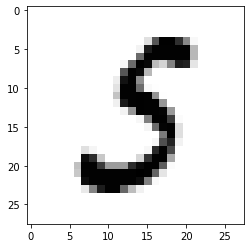

In [23]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1,1, 28, 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()


---

# CNN vs. deep CNN
- Deep layers does NOT guarantee the enhancement of accuracy.
- LR scheduling works fine enough to get higher accuracy.

---